In [1]:
#@title Define if we are on Colab and mount drive { display-mode: "form" }
try:
  from google.colab import drive
  drive.mount('/content/gdrive')
  IN_COLAB = True
except:
  IN_COLAB = False

In [ ]:
#@title (COLAB ONLY) Code for setting the environment, installation of packages { display-mode: "form" }
%%capture
if IN_COLAB:
  %env PYTHONPATH=
  !wget https://repo.continuum.io/miniconda/Miniconda3-4.5.4-Linux-x86_64.sh
  !chmod +x Miniconda3-4.5.4-Linux-x86_64.sh
  !./Miniconda3-4.5.4-Linux-x86_64.sh -b -f -p /usr/local
  !conda install --channel defaults conda python=3.6 --yes -q
  !conda update --channel defaults --all --yes -q
  import sys
  sys.path.insert(0, "/usr/local/lib/python3.6/site-packages")

  # !pip install fastai pydicom kornia fastcore==1.0.9 --upgrade --quiet
  !conda config --add channels conda-forge
  !conda install -c fastai -c pytorch fastai fastcore=1.0.9 pydicom gdcm kornia scikit-image scikit-learn pandas numpy ipykernel xlrd --yes -q

In [ ]:
#@title (COLAB ONLY) Clone GitHub repo { display-mode: "form" }

if IN_COLAB:
  from getpass import getpass
  user = getpass('GitHub user')
  password = getpass('GitHub password')
  import os
  os.environ['GITHUB_AUTH'] = user + ':' + password
  !git clone https://$GITHUB_AUTH@github.com/lluissalord/radiology_ai.git

  %cd radiology_ai

In [2]:
if IN_COLAB:
  PATH_DRIVER = '/content/gdrive/My Drive/'
  DATA_FOLDER = 'Dataset/'
else:
  PATH_DRIVER = ''
  DATA_FOLDER = 'data/'

In [3]:
import os

from fastai.basics import *
from fastai.callback import *
from fastai.vision.all import *
from fastai.vision.widgets import *
from fastai.medical.imaging import *

In [4]:
filename_prefix = 'IMG_'

PATH_PREFIX = os.path.join(PATH_DRIVER, DATA_FOLDER, '')
raw_folder = PATH_PREFIX + 'DICOMS'
organize_folder = PATH_PREFIX + 'pending_classification'
doubt_folder = PATH_PREFIX + 'doubt'
train_folder = PATH_PREFIX + 'train'

all_check_DICOM_dict = {
    'ap': {
        'SeriesDescription': ['RODILLA AP'],
        'BodyPartExamined': ['LOWER LIMB', 'KNEE']
    },
    'lat': {
        'SeriesDescription': ['RODILLA LAT'],
        'BodyPartExamined': ['LOWER LIMB', 'KNEE']
    },
    'two': {
        'SeriesDescription': ['RODILLAS AP'],
        'BodyPartExamined': ['LOWER LIMB', 'KNEE']
    },
    'other': {
        'BodyPartExamined': ['THORAX', 'UPPER LIMB', 'KNEE STANDING',
       'RIBS', 'HAND', 'HIP', 'PIE EN CARGA', 'FOOT', 'ANKLE',
       'ELBOW', 'PELVIS', 'LSPINE', 'CSPINE']
    }
}

targets = list(all_check_DICOM_dict.keys())

metadata_labels_path = os.path.join(PATH_PREFIX, 'metadata_labels.csv')

In [5]:
raw_fnames = get_files(raw_folder)
n_samples = 50 # None

In [22]:
from utils import check_DICOM
from tqdm import tqdm

# Initialize lists containing the filenames for each class
all_fnames = {}

# Open all the files as DICOM and check to which classification have to be placed
for fname in tqdm(raw_fnames, desc='Files: '):
    
    # Read and check DICOM
    dcm = fname.dcmread()
    for label, check_DICOM_dict in all_check_DICOM_dict.items():
        if check_DICOM(dcm, check_DICOM_dict):
            if label in all_fnames:
                all_fnames[label].append(fname)
            else:
                all_fnames[label] = [fname]

Files: 100%|██████████| 1738/1738 [00:04&lt;00:00, 347.61it/s]


In [23]:
import random

# Oversampling of all classes to meet the biggest one or reach max_n_times its own size
max_samples = max([len(fnames) for _, fnames in all_fnames.items()])
max_n_times = 4
for label, fnames in all_fnames.items():
    k = min(max_samples-len(fnames), max_n_times * len(fnames))
    all_fnames[label] = all_fnames[label] + random.choices(all_fnames[label], k=k)

In [25]:
from preprocessing import DCMPreprocessDataset

for label, fnames in all_fnames.items():

    dataset = DCMPreprocessDataset(fnames=fnames, padding_to_square=True, resize=256)
    bins = dataset.init_bins(n_samples=n_samples)
    # dataset.bins = bins

    folder = os.path.join(train_folder, label)
    dataset.save(folder, overwrite=False, clean_folder=True)

Saving Images: 100%|██████████| 610/610 [04:04&lt;00:00,  2.49it/s]


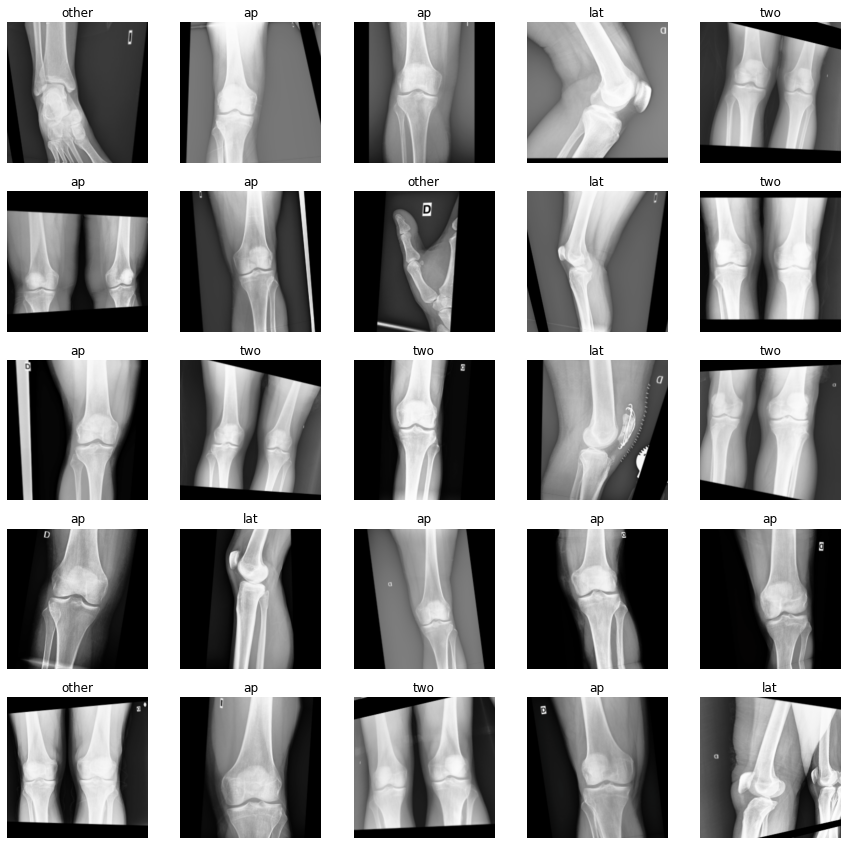

In [29]:
dls = ImageDataLoaders.from_folder(train_folder, valid_pct=0.2, shuffle_train=True, bs=32, batch_tfms=aug_transforms(), num_workers=0)
dls.show_batch(max_n=25)

In [62]:
# Define the callbacks that will be used during training
callback_fns = [
        MixUp(),
        # partial(OverSamplingCallback),
        # ShowGraph
    ]
roc_auc = RocAuc()
f1_score = F1Score(average='macro')
precision = Precision(average='macro')
recall = Recall(average='macro')
learn = cnn_learner(
    dls,
    resnet18,
    metrics=[
        error_rate,
        roc_auc,
        f1_score,
        precision,
        recall
    ],
    callback_fns=callback_fns
)

# Regularization by using float precision of 16 bits
# This helps to not overfit because is more difficult to "memorize" images, but enough to learn
learn = learn.to_fp16()

In [50]:
# learn.lr_find()

In [63]:
learn.fine_tune(5, 0.01, freeze_epochs=5)

epoch     train_loss  valid_loss  error_rate  roc_auc_score  f1_score  precision_score  recall_score  time    
0         0.968305    0.394590    0.136276    0.976774       0.853428  0.851173         0.858819      00:16     
1         0.635072    0.281431    0.086372    0.986405       0.903011  0.902886         0.907326      00:16     
2         0.486699    0.243146    0.072937    0.987637       0.924512  0.926517         0.925607      00:15     
3         0.450605    0.367633    0.128599    0.980094       0.861421  0.855679         0.871192      00:15     
4         0.450980    0.182663    0.069098    0.994153       0.929378  0.926830         0.932334      00:16     
epoch     train_loss  valid_loss  error_rate  roc_auc_score  f1_score  precision_score  recall_score  time    
0         0.466553    0.215356    0.069098    0.991016       0.928845  0.935564         0.923418      00:18     
1         0.349953    0.192598    0.069098    0.993316       0.930279  0.940816         0.925916    

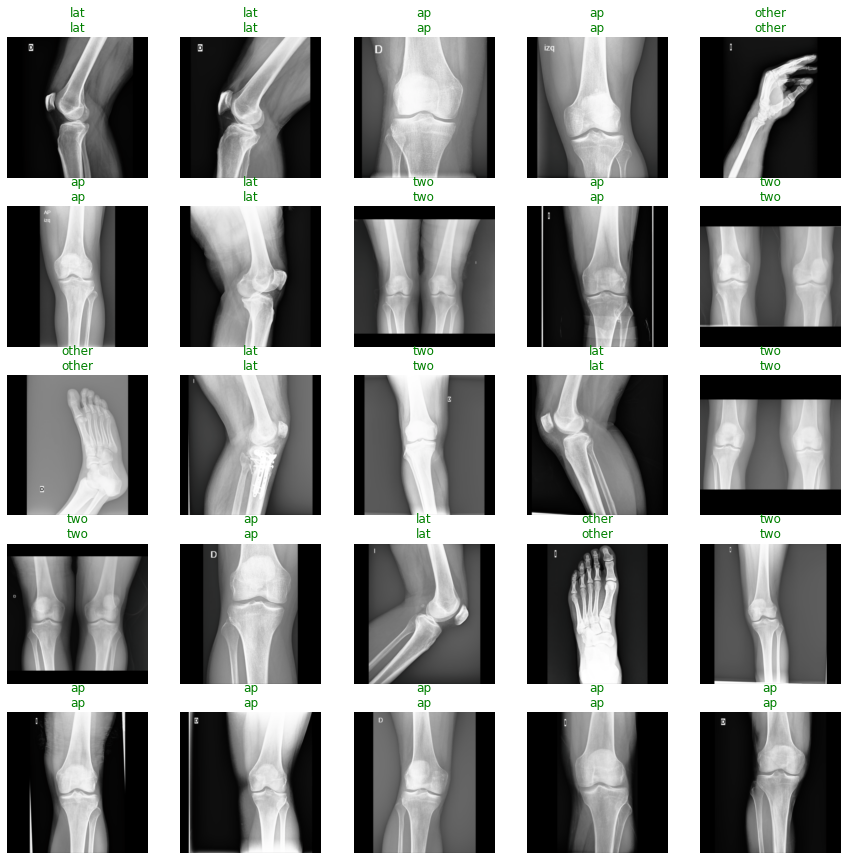

In [64]:
learn.show_results(max_n=25)

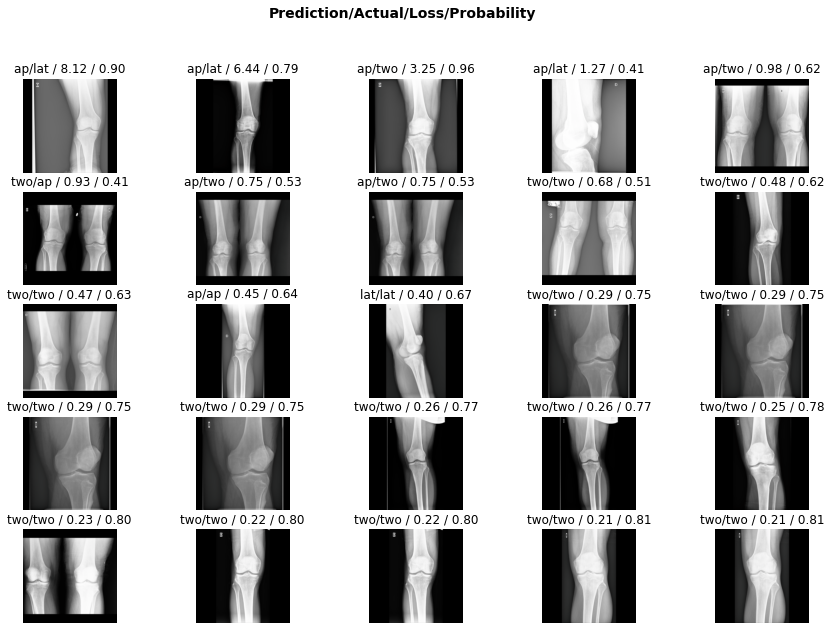

In [65]:
interp = Interpretation.from_learner(learn)
losses, idx = interp.top_losses()
interp.plot_top_losses(25, figsize=(15,10))

In [66]:
paths = learn.dls.train.items + learn.dls.valid.items
labels = [path.parent.name for path in paths]
dl = learn.dls.test_dl(paths)
preds, _ = learn.get_preds(dl=dl)
max_probs, targs = preds.max(1)

In [103]:
from glob import glob

class_threshold = {
    'Correct_label': 0.95,
    'Wrong_label': 0.95,
}

raw_paths = glob(
    os.path.join(
        raw_folder,
        '*',
        '*'
    )
)
raw_paths = [os.path.normpath(raw_path) for raw_path in raw_paths]

raw_path_df = pd.DataFrame(raw_paths, columns=['Raw_path'])

raw_path_df = raw_path_df.set_index(raw_path_df['Raw_path'].str.split(os.sep).str[-1])

In [104]:
data = {
    'Path': [],
    'Raw_path': [],
    'Label': [],
    'Raw_pred': [],
    'Pred': [],
    'Prob': [],
}
to_be_reviewed = []
for label, prob, targ, path in zip(labels, max_probs, targs, paths):
    raw_pred = targets[targ]
    if label == targets[targ]:
        if prob >= class_threshold['Correct_label']:
            pred = raw_pred
        else:
            pred = 'Unsure_' + targets[targ] + '_' + label
            to_be_reviewed.append((path, targets[targ], label, prob))

    else:
        if prob >= class_threshold['Wrong_label']:
            pred = raw_pred
        else:
            final_pred = 'Unsure_' + targets[targ] + '_' + label
            to_be_reviewed.append((path, targets[targ], label, prob))
    try:
        raw_path = raw_path_df.loc[os.path.splitext(path.name)[0], 'Raw_path']
    except KeyError as e:
        row_match = raw_path_df.index.str.startswith(os.path.splitext(path.name)[0])
        proposal_raw_path = raw_path_df.loc[row_match]
        if len(proposal_raw_path) == 1:
            raw_path = proposal_raw_path['Raw_path'][0]
        elif os.path.splitext(path.name)[0][-2] == '_' or os.path.splitext(path.name)[0][-3] == '_':
            continue
        else:
            raw_path = ''
            print(f'Error fetching `{os.path.splitext(path.name)[0]}` image. Due to {e}')
            continue

    data['Path'].append(os.path.normpath(path).replace(os.sep, '/'))
    data['Raw_path'].append(os.path.normpath(raw_path).replace(os.sep, '/'))
    data['Label'].append(label)
    data['Raw_pred'].append(raw_pred)
    data['Pred'].append(pred)
    data['Prob'].append(float(prob))

df = pd.DataFrame(data)
df.to_csv(metadata_labels_path, index=False)

In [105]:
def _open_thumb(fn, h, w): return Image.open(fn).to_thumb(h, w).convert('RGBA')

class ImagesCleanerDefaultPred(ImagesCleaner):
    "A widget that displays all images in `fns` along with a `Dropdown` with default value the prediction"

    def set_fns(self, fns, preds, labels, probs):
        self.fns = L(fns)[:self.max_n]
        # ims = parallel(_open_thumb, self.fns, h=self.height, w=self.width, progress=False,
        #                n_workers=min(len(self.fns)//10,defaults.cpus))
        ims = [_open_thumb(fn, h=self.height, w=self.width) for fn in self.fns]
        self.widget.children = [
            VBox([
                Label(f'{pred}/{label}/{prob:.4f}'),
                widget(im, height=f'{self.height}px'),
                Dropdown(options=self.opts, layout={'width': 'max-content'}, value=pred)
            ]) for im, pred, label, prob in zip(ims,preds,labels,probs)
        ]

    def values(self): return L(self.widget.children).itemgot(-1).attrgot('value')

In [106]:
df_to_review = df[~df['Pred'].isin(targets)]
w = ImagesCleanerDefaultPred(targets,  max_n=len(df_to_review.index))
w.set_fns(
    list(df_to_review['Path']),
    list(df_to_review['Raw_pred']),
    list(df_to_review['Label']),
    list(df_to_review['Prob'])
)
w

Box(children=(VBox(children=(Label(value=&#39;ap/ap/0.9151&#39;), Output(layout=Layout(height=&#39;128px&#39;)), Dropdown(inde…

In [107]:
w.change()

(#42) [(0, &#39;ap&#39;),(1, &#39;lat&#39;),(2, &#39;ap&#39;),(3, &#39;ap&#39;),(4, &#39;lat&#39;),(5, &#39;lat&#39;),(6, &#39;ap&#39;),(7, &#39;two&#39;),(8, &#39;ap&#39;),(9, &#39;ap&#39;)...]

In [108]:
df['Final_pred'] = df['Pred']
for i, pred in w.change():
    idx = df_to_review.iloc[i].name
    df.loc[idx, 'Final_pred'] = pred
    df.loc[idx, 'Prob'] = np.nan
df.to_csv(metadata_labels_path, index=False)

In [ ]:
import shutil
shutil.rmtree(train_folder)